<a href="https://colab.research.google.com/github/omendez930/Dog-Vision-Multi-class-Classifier/blob/main/End_to_end_Dog_Vision_Multiclass_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog breed classification

This notebook builds an end-to-end milti-class image classifier using tenaorflow 2.0 and tensorflow hub.

## 1. Problem
 Identifying the bree of dog given an image of a dog

 When taking a photo of a dog, I want to know what bredd of dog it is.

 ## 2. Data

 Teh data we're using is from Kaggles dog breed identfication competition.

 https://www.kaggle.com/c/dog-breed-identification/overview

 ## 3. Evaluation

 The evaluation is a file with prediction proobagbilities for each dog breed of each test image

 www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

 ## 4. Features

 Some information about the data:
 * We're dealing with images (unstructured data) so it wold be best to use deep learninig/Transfer learning.
 * There are 120 breeds of dogs (120 different classes)
 *There are around 10,000+ images in the traing set (these images ahve labels)
 *There are around 10,000+ images in the test set (these images have no labels)

In [1]:
# Unzip the zip file from google drive
# !unzip "drive/MyDrive/Dog vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog vision"

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### Get our workspace ready

* Import TensorFlow
* Import tensorflow hub
* Make sure you're using a GPU

In [3]:
# import Tensorflow into colab

import tensorflow as tf
import tensorflow_hub as hub
print("TF Version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# check got GPU availability
print("GPU", "Available (YESSSS!)" if tf.config.list_physical_devices("GPU") else "Not available")

TF Version: 2.19.0
TF Hub version: 0.16.1
GPU Available (YESSSS!)


### Getting our data ready (tyurnin into tensors)

With all machine learning models, ou data has to be in numerical format. So that's what we'll be doing frist. Turning our images into tensors (numerical respresentations)

We'll start by accessing our datand and checking the labels

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
%matplotlib inline
from sklearn.model_selection import train_test_split
from IPython.display import Image


In [5]:
# checkout the labrls of our data
labels_csv = pd.read_csv("drive/MyDrive/Dog vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

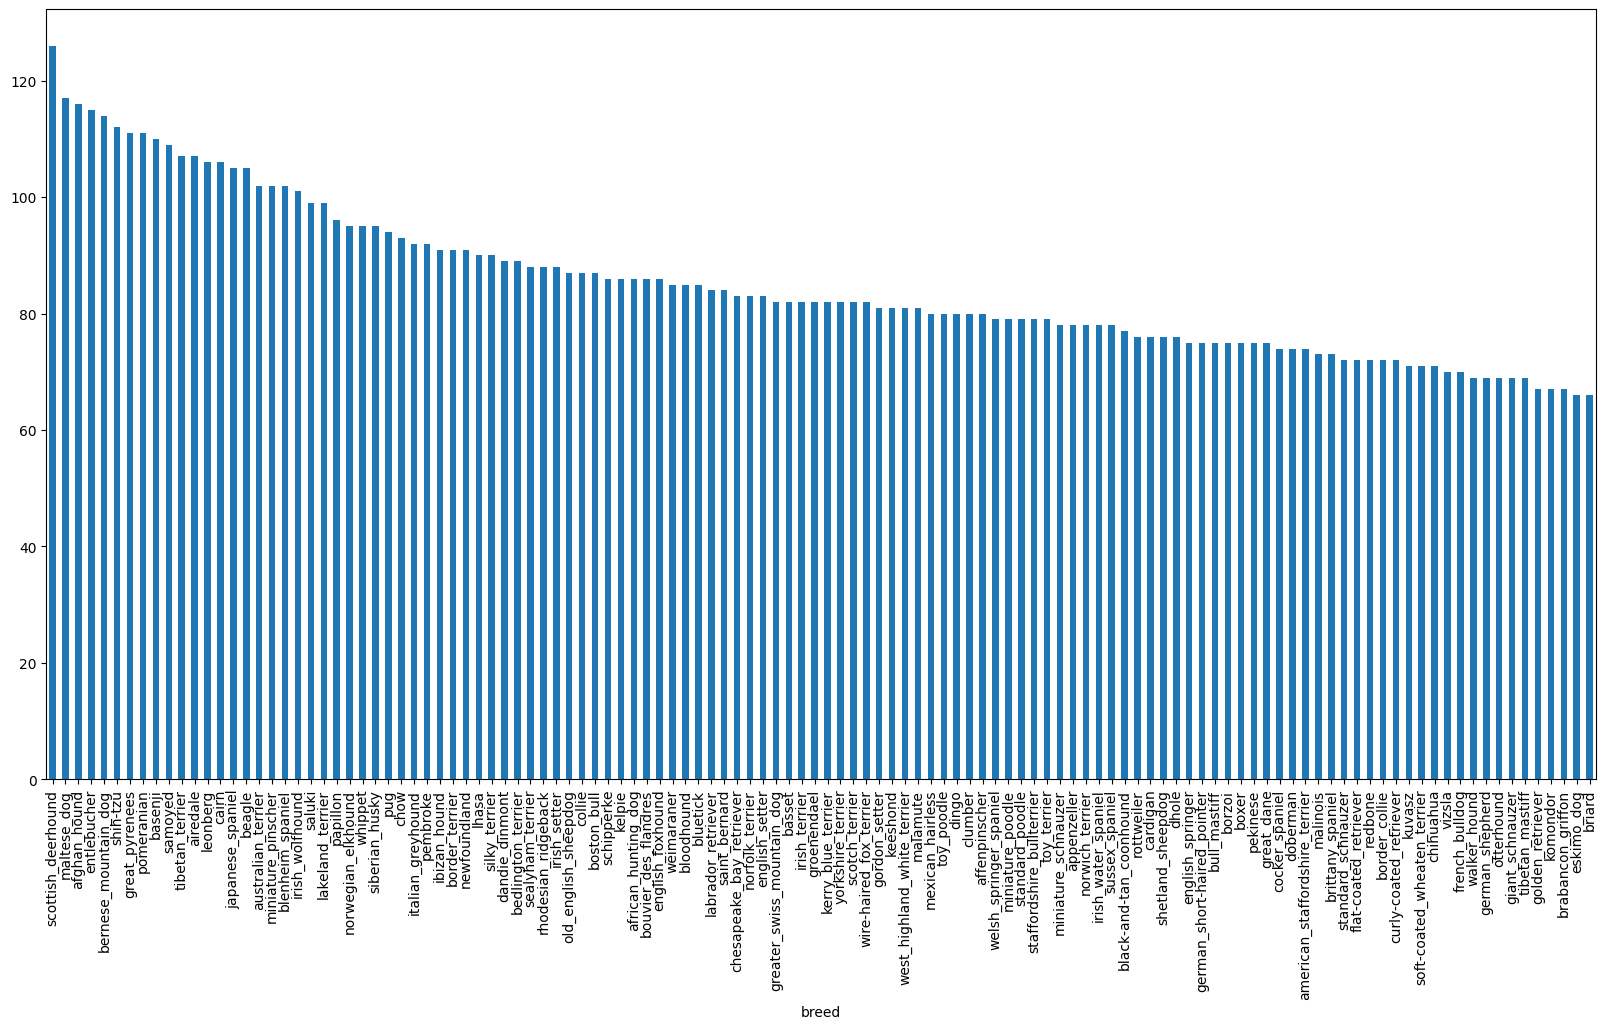

In [7]:
# How many images are there of each breed?

labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [8]:
labels_csv['breed'].value_counts().median()

82.0

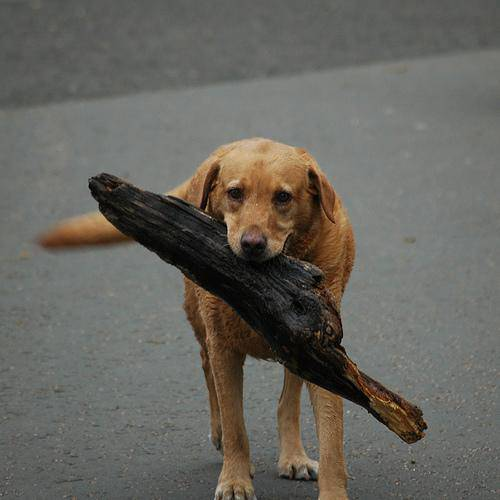

In [9]:
# Let's view an image

Image('drive/MyDrive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg')

### Getting images and their labels

Let's get a list of all our images

In [10]:
# Create a pathname from image ID's

filenames = ["drive/MyDrive/Dog vision/train/" + fname + ".jpg"for fname in labels_csv['id']]


filenames[:10]

['drive/MyDrive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check whether number of filenames matches number of actual files

if len(os.listdir("drive/MyDrive/Dog vision/train/")) == len(filenames):
  print("Filenames match actual amount of file!! Proceed.")
else:
  print("Filenames do not match the actual amount of files, check target directory.")

Filenames match actual amount of file!! Proceed.


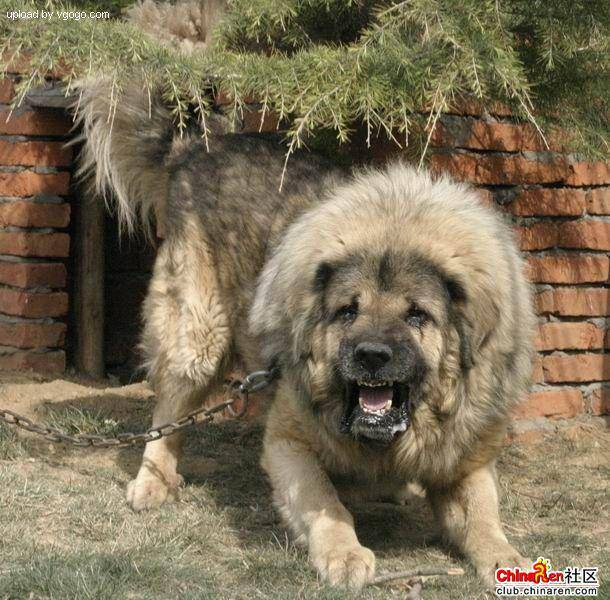

In [12]:
# One more check
Image(filenames[9000])

Since we've now got our training image filepath in a list, let's prepare our labels.

In [13]:
labels= labels_csv['breed']
labels = np.array(labels)
# labels = labels_csv['breed'].to_numpt() -- does the same thing
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print('Number of labels matches number of filenames!')
else:
  print('Number of labels does not match number of filenames, check the filepath')

Number of labels matches number of filenames!


In [16]:
# Find the unique label values

unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [17]:
# Turn a single label into an array of booleans

print(labels[0])

labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# Turn every labe into a bollena array

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [19]:
len(boolean_labels)

10222

 # Creating our own validation set

 Since the dataset from Kaggle doesn't come with a validation set, we're goin gto create our own

In [20]:
# Setup x and y variables

X = filenames
y = boolean_labels

We're going to start wiht 1000 images and increase as needed.

In [21]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: 'slider', min:1000, max:10000, step:1000}

In [22]:
# Let's split the data to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [23]:
# Having a peek at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

### Preprocessing Images (turning images into Tensors)

To preprocess our images into tensors we're going to a function which does a few things:

1. Take an image filepath as input
2. User TensorFlow to read the files and save it to a variable
3. Turn our image (a jpf) into a  Tensor
4. Normalize our image (convert color channel values from 0-255 to 0-1)
4. Resize the image to be a shape of (224,224)
5. Return the modified image

Before we do, let's see what importing an image looks like,

In [24]:
# Convert an image to anumpy array

image = imread(filenames[42])

image.shape

(257, 350, 3)

In [25]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a tensor, let's make a function to preprocess them.



In [30]:
#Define image size
IMG_SIZE = 224

# create a function for preprocessing images
def preprocess_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns it into a tensor
  """

  # Read in the image path
  image = tf.io.read_file(image_path)

  # Turn jpg image into numerical Tensor with 3 color channel (RGB)
  image = tf.image.decode_jpeg(image, channels=3)

  # Conver the color channel values from 0-255 to 0-1 Values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


### Turning our data into batches

Why turn our data into batches?

If we're trying to process all 10k images at once, it might not fit into memory.

So we will do 32 (this is the batch size) images at a time. You can manual adjust the batch.

IN order to use TensorFLow effectively, we need our data in the for of Tensor tuples which look like this:
`(image, label)`

In [31]:
# Function to return a tuple of tensors (image, label)

def get_image_label(image_path, label):

  '''
  Takes and image file path and the associated label, processes image and returns a tuple of (image, label).
  '''
  image = preprocess_image(image_path)
  return image, label

In [35]:
# Demo of the above

#image in a Tensor, label is note
# (preprocess_image(X[42]), y[42])

# Image and Label in a tensor
(preprocess_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now that we have a way to turn our data into tuples of tensors in the form of : `(image,label)`, let's make a function to tyurn all of our data (`X` & `y`) into batches.

In [36]:
from tensorflow.python.data.ops.readers import from_tensor_slices_op
# Define the batch size, 32 is a good start

BATCH_SIZE = 32

# create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  '''
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles data if it's training data but doesn't shuffle if it's validation data.
  Also accepts tests data as input (no labels).
  '''

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("creating test data batches...")
    #takes tensorflow dataset and turns it into data
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    # Map or processed image into batches of 32
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  # if the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("creating training data batches...")
    # Trun filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    #shuffling pathnames and labels before mapping image processor s faster than suffling images
    data = data.shuffle(buffer_size=len(X))

    # create (image, label) tuples (this alo turns the image path into a preprocessed image)
    data = data.map(get_image_label) # takes longer if you don't shuffle first

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [37]:
# traiing and vbalidation batches
train_data =  create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

creating training data batches...
Creating validation data batches...


In [38]:
# check out the different attributes of data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches

Our data is now in batches, however these can be hard to understand/comprehend. Let's visualize them

In [48]:
# Create a function for viewinf images in a data batch

def show_25_images(images, labels):
  '''
  Displays a plot of 25 images and their labels froma  data batch.
  '''

  # Setup figure
  plt.figure(figsize=(20,10))
  # Loop throug 25 (for displaying 25 images)
  for i in range(25):
    #create a subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [44]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels # lenngth is (32,32)

(array([[[[0.723998  , 0.60333973, 0.50288457],
          [0.7875799 , 0.6793165 , 0.5969636 ],
          [0.84580886, 0.7640862 , 0.6980497 ],
          ...,
          [0.34156093, 0.22783543, 0.1572472 ],
          [0.34473038, 0.22375701, 0.13961825],
          [0.33597687, 0.21832979, 0.12421213]],
 
         [[0.7591049 , 0.6384466 , 0.53799146],
          [0.7712554 , 0.662992  , 0.5806391 ],
          [0.8537613 , 0.77203864, 0.7060022 ],
          ...,
          [0.33364844, 0.21207984, 0.14086136],
          [0.33496624, 0.2139929 , 0.12985413],
          [0.3259191 , 0.20827202, 0.11415437]],
 
         [[0.7199351 , 0.59927684, 0.49882168],
          [0.84258157, 0.73431826, 0.6519653 ],
          [0.838531  , 0.75680834, 0.6907719 ],
          ...,
          [0.3233841 , 0.2018155 , 0.12338411],
          [0.33661377, 0.21726646, 0.12824962],
          [0.3287909 , 0.21114385, 0.11702619]],
 
         ...,
 
         [[0.6470325 , 0.5043168 , 0.36473268],
          [0.58006

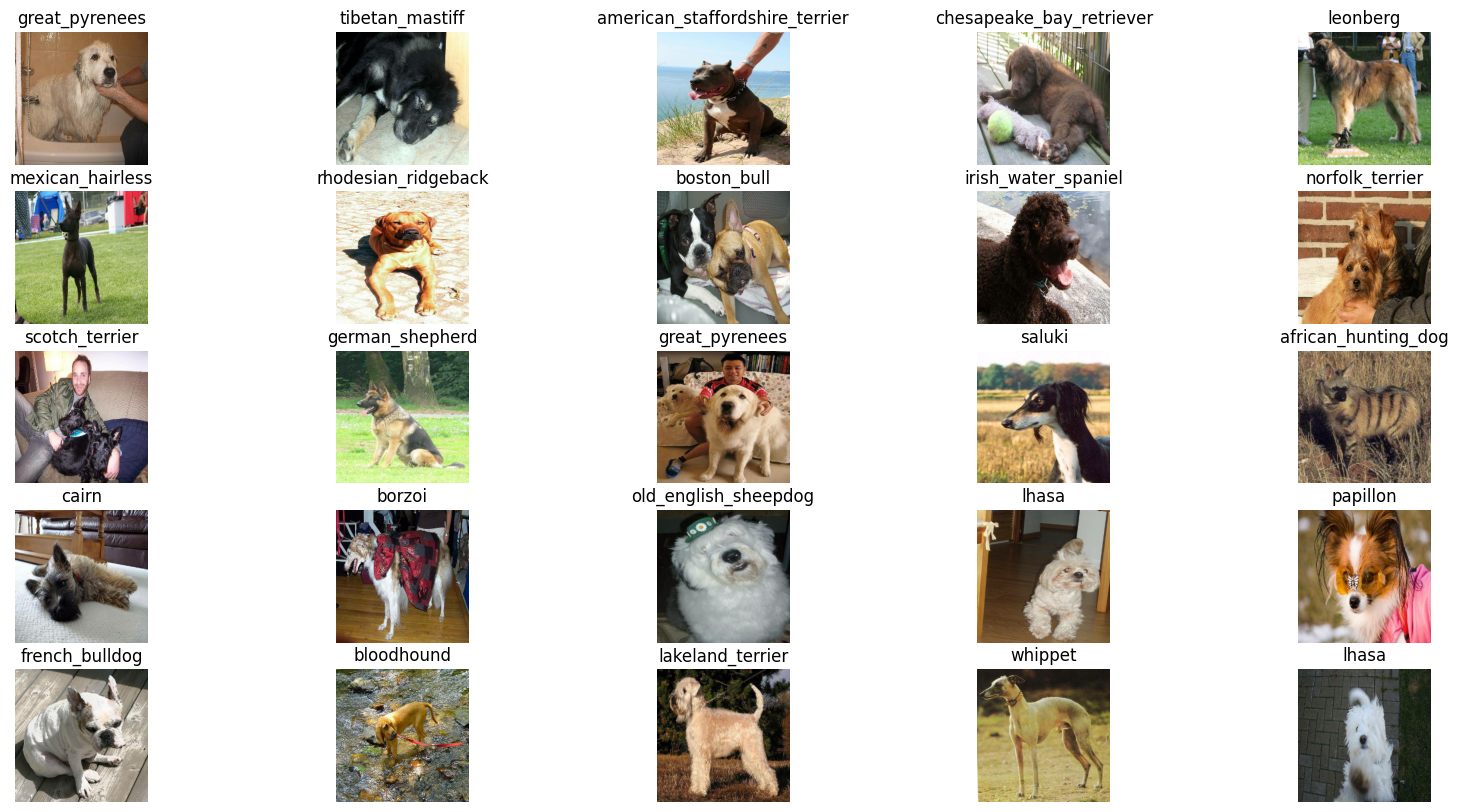

In [51]:
show_25_images(train_images, train_labels)

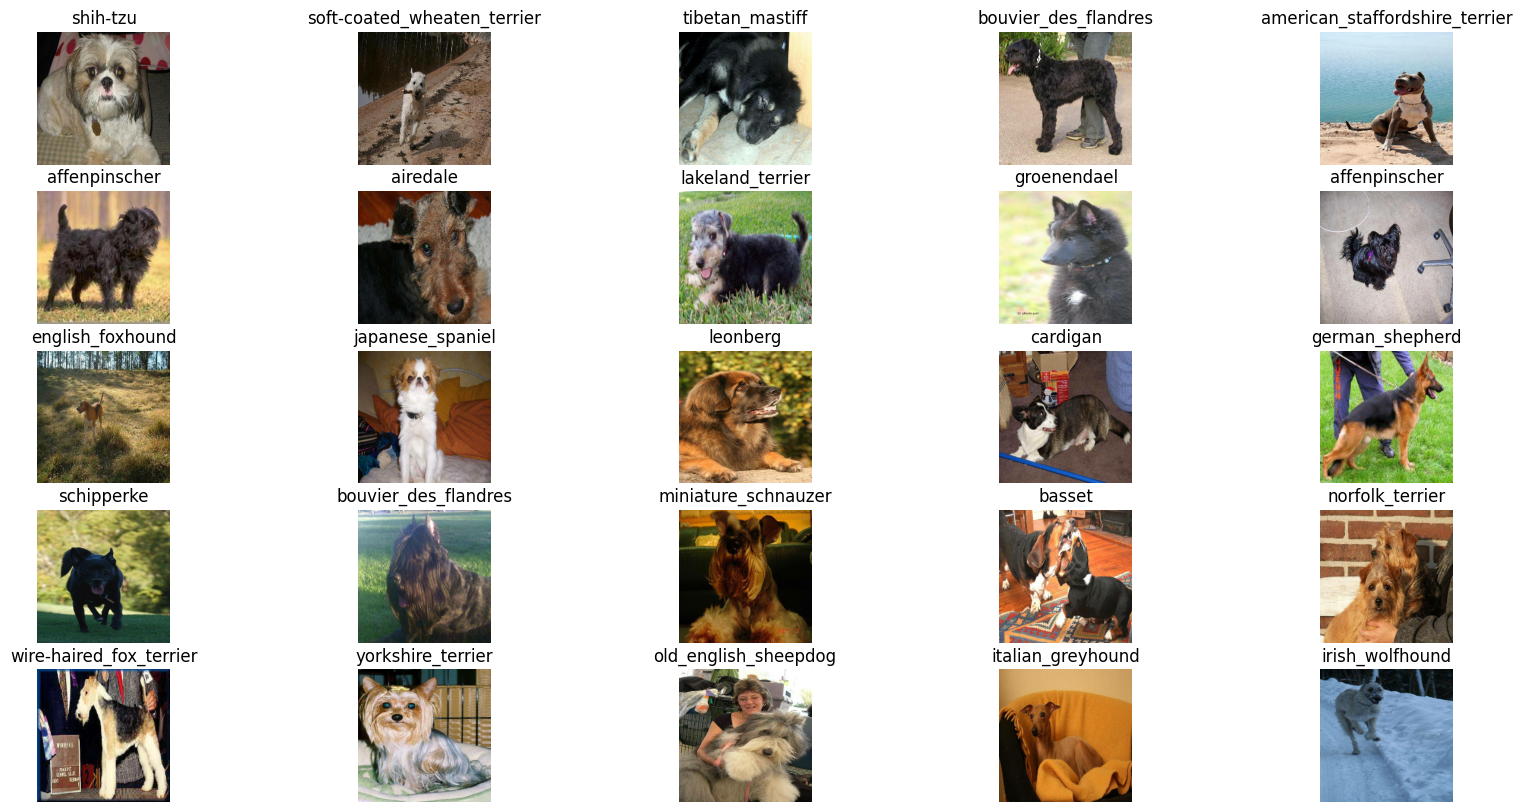

In [52]:
# Now let's visualize our validation set
val_images, val_labels = next(train_data.as_numpy_iterator())
show_25_images(val_images, val_labels)